In [2]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score 
from dataFrameCovid import DataFrameCovid as dfc
from sklearn.metrics import classification_report
from geraArquivo1 import GeraArquivo as ga

In [3]:
# Monta dataframe com nome dos arquivos
df = dfc.getDf()

d:\DropB\Faculeste\TCC\codigos\dataFrameCovid.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [4]:
# Variáveis de controle
nImagens = len(df)
percentual = 0.8
tamanhoDoLote = 200
epocas = 50
passosPorEpoca = int(nImagens*percentual // tamanhoDoLote)
passosPorValidacao = int(nImagens*(1.0 - percentual) // tamanhoDoLote)
width = 64
height = 64
depth = 3
classes = 2
inputShape = (height, width, depth)
passosPorEpoca, passosPorValidacao

(27, 6)

In [5]:
# gerando dataframes de treinamento e de teste
dfTreinamento = df.sample(frac=0.8, random_state=100) # 70% de treinamento
dfTeste = df[~df['arquivo'].isin(dfTreinamento['arquivo'])]     # 30% de teste

In [6]:
imgGen = ImageDataGenerator(rescale = 1./255, 
                            shear_range=0.25, 
                            zoom_range = 0.25, 
                            horizontal_flip = True)

conjTreinamento = imgGen.flow_from_dataframe(dfTreinamento, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

conjTeste = imgGen.flow_from_dataframe(dfTeste, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

Found 5440 validated image filenames belonging to 2 classes.
Found 1360 validated image filenames belonging to 2 classes.


In [7]:
from modVgg16Net import Vgg16NetM
vggClf = Vgg16NetM()
vggClf = vggClf.build(width=width, height=height, depth=3, classes=2)
vggClf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 64)        0         
                                                        

c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
print("VGG 16 Net ***************************************************")
h1 = vggClf.fit(x=conjTreinamento, steps_per_epoch=passosPorEpoca, epochs=epocas, validation_data=conjTeste, validation_steps=passosPorValidacao, verbose=1).history

VGG 16 Net ***************************************************


Epoch 1/20
27/27 [==============================] - 558s 20s/step - loss: 1.0750 - accuracy: 0.6498 - val_loss: 774.4764 - val_accuracy: 0.4650
Epoch 2/20
27/27 [==============================] - 499s 18s/step - loss: 0.7499 - accuracy: 0.7704 - val_loss: 98.5963 - val_accuracy: 0.4558
Epoch 3/20
27/27 [==============================] - 491s 18s/step - loss: 0.6890 - accuracy: 0.8044 - val_loss: 5.0784 - val_accuracy: 0.4783
Epoch 4/20
27/27 [==============================] - 485s 18s/step - loss: 0.6611 - accuracy: 0.8143 - val_loss: 1.9715 - val_accuracy: 0.5425
Epoch 5/20
27/27 [==============================] - 518s 19s/step - loss: 0.6229 - accuracy: 0.8376 - val_loss: 2.6065 - val_accuracy: 0.5500
Epoch 6/20
27/27 [==============================] - 489s 18s/step - loss: 0.6797 - accuracy: 0.8116 - val_loss: 1.2204 - val_accuracy: 0.6767
Epoch 7/20
27/27 [==============================] - 488s 18s/step - loss: 0.6405 - accuracy: 0.8271 - val_loss: 2.3245 - val_accuracy: 0.5758
Epo

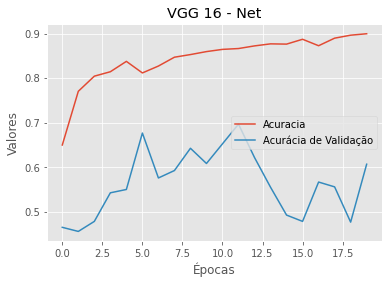

In [9]:
# Gráfico de Acurácia
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epocas), h1["accuracy"], label="Acuracia")
#plt.plot(np.arange(0, epc), h1["loss"], label="Perda")
plt.plot(np.arange(0, epocas), h1["val_accuracy"], label="Acurácia de Validação")
#plt.plot(np.arange(0, epc), h1["val_loss"], label="Perda na Validação")
plt.title("VGG 16 - Net")
plt.xlabel("Épocas")
plt.ylabel("Valores")
plt.legend()
plt.show()

In [10]:
prdVgg = vggClf.predict(conjTeste[0][0])
categorias = []
for i in conjTeste[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
predVggNet = []
for i in prdVgg:
    predVggNet.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, predVggNet, target_names=["Não Covid", "Covid"]))

7/7 [==============================] - 4s 508ms/step
              precision    recall  f1-score   support

   Não Covid       0.70      0.43      0.53       114
       Covid       0.50      0.76      0.60        86

    accuracy                           0.57       200
   macro avg       0.60      0.59      0.57       200
weighted avg       0.61      0.57      0.56       200



In [11]:
ga.geraHistorico("arquivos/arqVggNet"+str(epocas)+".csv", h1)
ga.geraPredicao("arquivos/arqPredVggNet"+str(tamanhoDoLote)+".csv", categorias, predVggNet)

In [12]:
'''
df1 = dfc.getDfPredicao()
prdTmnh = len(df1)
conjPred = imgGen.flow_from_dataframe(df1, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                x_col = 'arquivo',
                                y_col = 'categoria',
                                target_size=(width, height), 
                                batch_size=prdTmnh, 
                                class_mode='categorical')
prdLNt = lntClf.predict(conjPred[0][0])
categorias = []
for i in conjPred[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
prdLNet = []
for i in prdLNt:
    prdLNet.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, prdLNet, target_names=["Não Covid", "Covid"]))
'''


'\ndf1 = dfc.getDfPredicao()\nprdTmnh = len(df1)\nconjPred = imgGen.flow_from_dataframe(df1, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", \n                                x_col = \'arquivo\',\n                                y_col = \'categoria\',\n                                target_size=(width, height), \n                                batch_size=prdTmnh, \n                                class_mode=\'categorical\')\nprdLNt = lntClf.predict(conjPred[0][0])\ncategorias = []\nfor i in conjPred[0][1]:\n    categorias.append(0 if i[0] > 0.0 else 1)\nprdLNet = []\nfor i in prdLNt:\n    prdLNet.append(0 if i[0] >= 0.5 else 1)\nprint(classification_report(categorias, prdLNet, target_names=["Não Covid", "Covid"]))\n'